In [1]:
!pip3 install -r "requirements.txt"

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import pandas as pd
import random
from collections import defaultdict
import gym
import gym_minigrid
import matplotlib.pyplot as plt
import json
import os
import seaborn as sns
%matplotlib inline

In [3]:
class QLearning:
    def __init__(self, actions, agent_indicator=10, gamma=0.1):
        self.actions = actions
        self.agent_indicator = agent_indicator
        self.alpha = 0.01
        self.gamma = gamma
        self.epsilon = 0.2
        self.q_values = defaultdict(lambda: [0.0] * actions)
        
    def _convert_state(self, s):
        return np.where(s == self.agent_indicator)[0][0]
        
    def update(self, state, action, reward, next_state, next_action):
        state = self._convert_state(state)
        next_state = self._convert_state(next_state)
        
        q_value = self.q_values[state][action]
        
        ########################## Write Code ####################################
        
        next_q_value = max(self.q_values[next_state])
        td_error = reward + self.gamma * next_q_value - q_value
        self.q_values[state][action] = q_value + self.alpha * td_error
        
        ###########################################################################
    def act(self, state):
        #################### Write epsilion greedy code ###########################
        if np.random.rand() < self.epsilon:
            action = np.random.choice(self.actions)
        else:
            state = self._convert_state(state)
            q_values = self.q_values[state]
            action = int(np.argmax(q_values))
        ###########################################################################
        return action

In [4]:
from utils import gen_wrapped_env, show_video

In [5]:
!pip3 install ffmpeg

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [6]:
def compare_gamma(gamma, log_idx):
    env = gen_wrapped_env('MiniGrid-Empty-6x6-v0')
    # env = gen_wrapped_env('MiniGrid-DoorKey-5x5-v0')

    obs = env.reset()

    agent_position = obs[0]

    agent = QLearning(4, agent_position, gamma)

    rewards = []
    for ep in range(10000):
        done = False
        obs = env.reset()
        action = agent.act(obs)

        ep_rewards = 0
        while not done:
            next_obs, reward, done, info = env.step(action)

            next_action = agent.act(next_obs)

            agent.update(obs, action, reward, next_obs, next_action)

            ep_rewards += reward
            obs = next_obs
            action = next_action
        rewards.append(ep_rewards)
        if (ep+1) % 20 == 0:
            print("episode: {}, rewards: {}".format(ep+1, ep_rewards))
    rewards_qlearning = rewards
    env.close()
    
    # {s:np.round(q, 5).tolist() for s, q in agent.q_values.items()}

    # show_video()
    for idx in range(1, 5):
        with open(f'./logs/qtable_gamma{log_idx}.json', 'w') as f:
            json.dump({str(s): np.round(q, 5).tolist() for s, q in agent.q_values.items()}, f)
    

    pd.Series(rewards).to_csv('./logs/rewards_gamma%d.csv' %log_idx)

In [7]:
gammas = [0.1, 0.5, 0.9, 0.99]
for i in range(4):
    print("Trt %d, Gamma: %f" % (i+1, gammas[i]))
    compare_gamma(gammas[i], i+1)

Trt 1, Gamma: 0.100000
episode: 20, rewards: 0
episode: 40, rewards: 0
episode: 60, rewards: 0
episode: 80, rewards: 0
episode: 100, rewards: 0
episode: 120, rewards: 0
episode: 140, rewards: 0
episode: 160, rewards: 0
episode: 180, rewards: 0
episode: 200, rewards: 0
episode: 220, rewards: 0
episode: 240, rewards: 0
episode: 260, rewards: 0
episode: 280, rewards: 0
episode: 300, rewards: 0
episode: 320, rewards: 0
episode: 340, rewards: 0
episode: 360, rewards: 0
episode: 380, rewards: 0
episode: 400, rewards: 0
episode: 420, rewards: 0
episode: 440, rewards: 0
episode: 460, rewards: 0
episode: 480, rewards: 0
episode: 500, rewards: 0
episode: 520, rewards: 0
episode: 540, rewards: 0
episode: 560, rewards: 0
episode: 580, rewards: 0
episode: 600, rewards: 0
episode: 620, rewards: 0
episode: 640, rewards: 0
episode: 660, rewards: 0
episode: 680, rewards: 0
episode: 700, rewards: 0
episode: 720, rewards: 0
episode: 740, rewards: 0
episode: 760, rewards: 0
episode: 780, rewards: 0
episod

In [8]:
gamma1_logs = pd.read_csv('./logs/rewards_gamma1.csv', index_col=False).iloc[:, 1]
gamma2_logs = pd.read_csv('./logs/rewards_gamma2.csv', index_col=False).iloc[:, 1]
gamma3_logs = pd.read_csv('./logs/rewards_gamma3.csv', index_col=False).iloc[:, 1]
gamma4_logs = pd.read_csv('./logs/rewards_gamma4.csv', index_col=False).iloc[:, 1]

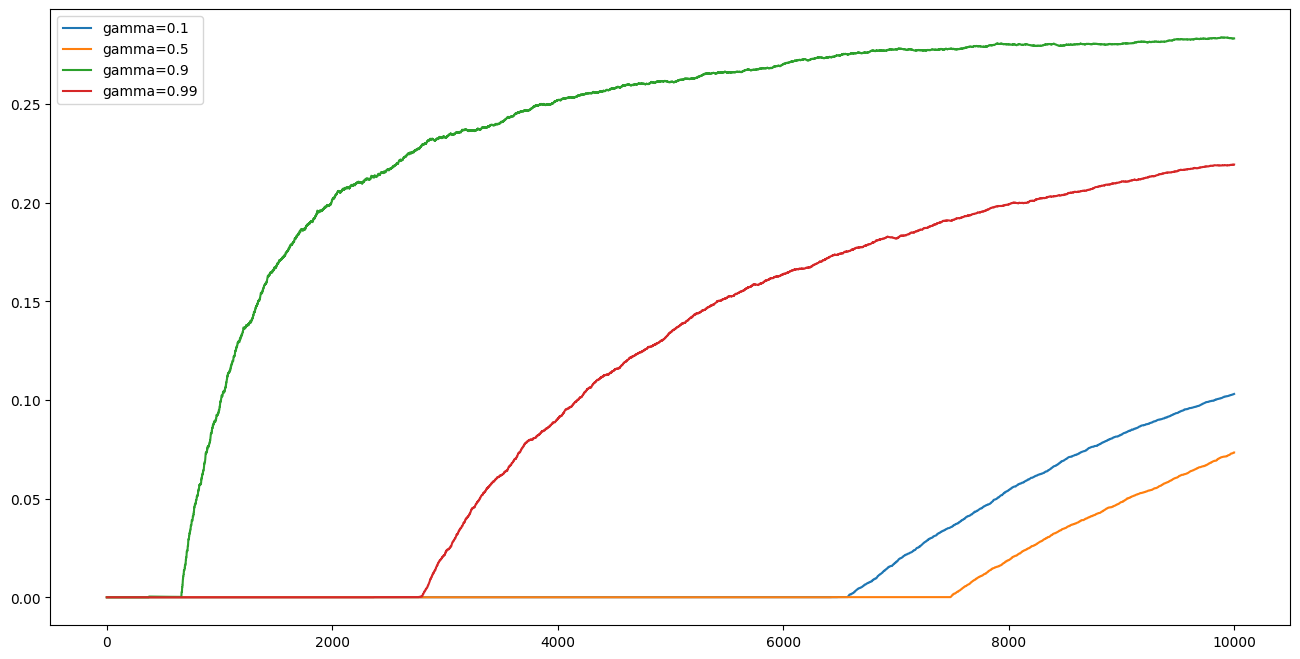

In [9]:
plt.figure(figsize=(16, 8))
plt.plot(gamma1_logs.cumsum() / (pd.Series(np.arange(gamma1_logs.shape[0]))+1), label="gamma=0.1")
plt.plot(gamma2_logs.cumsum() / (pd.Series(np.arange(gamma2_logs.shape[0]))+1), label="gamma=0.5")
plt.plot(gamma3_logs.cumsum() / (pd.Series(np.arange(gamma3_logs.shape[0]))+1), label="gamma=0.9")
plt.plot(gamma4_logs.cumsum() / (pd.Series(np.arange(gamma4_logs.shape[0]))+1), label="gamma=0.99")
plt.legend()

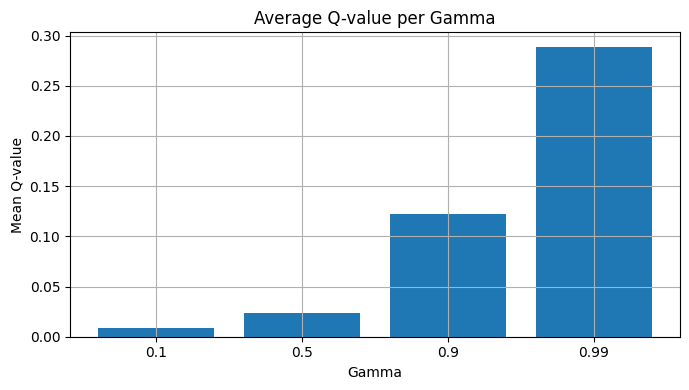

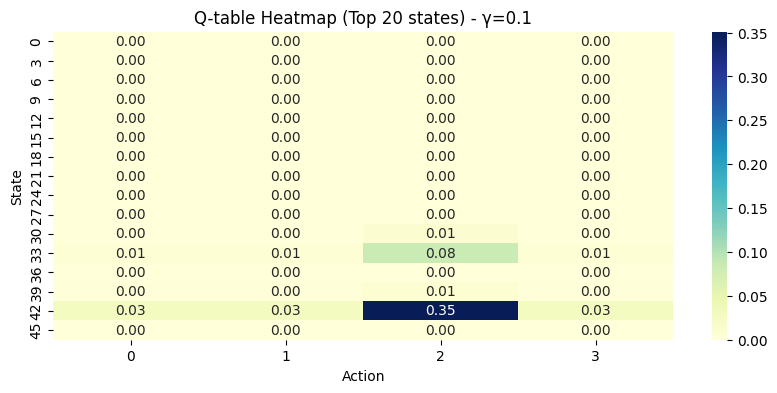

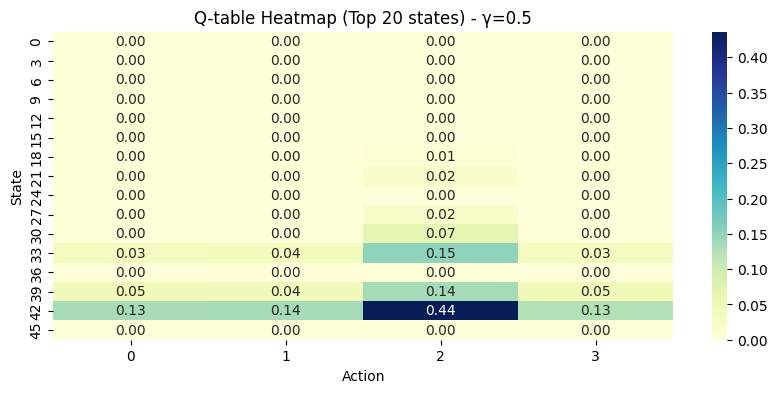

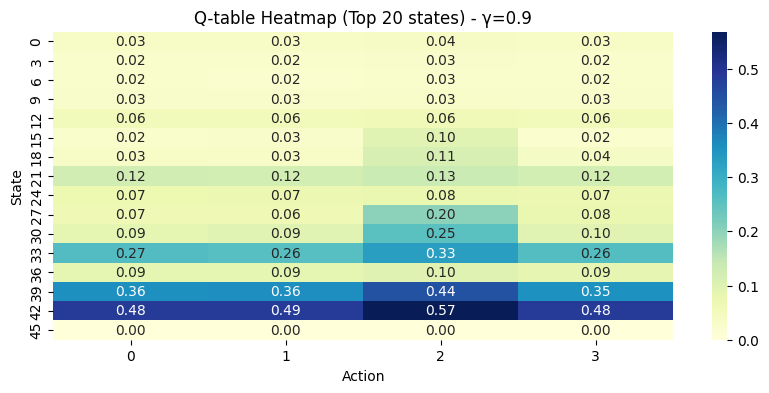

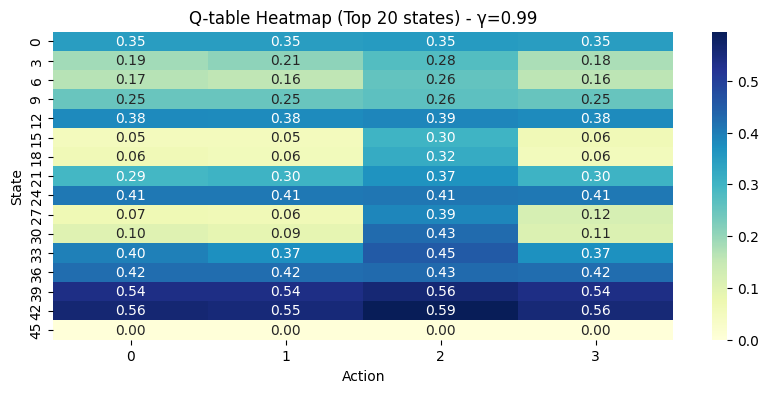

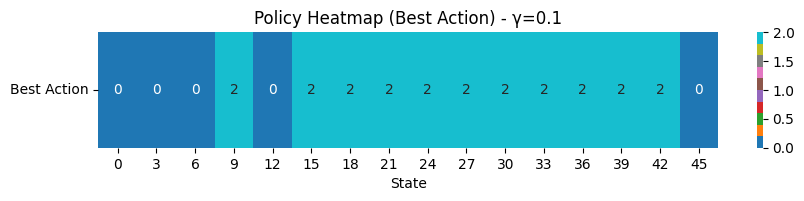

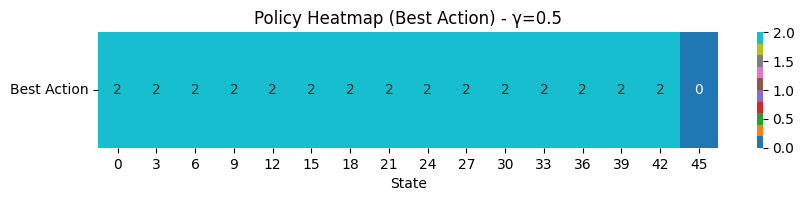

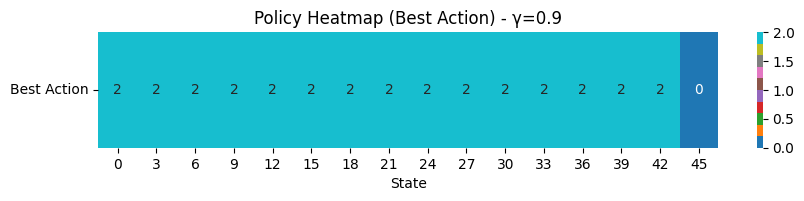

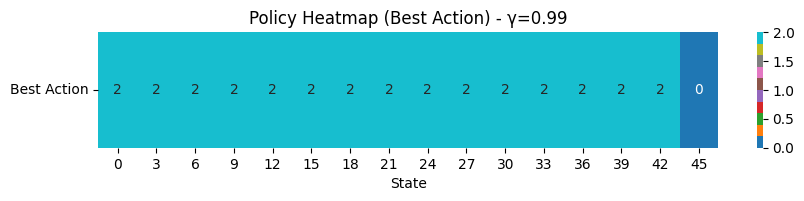

In [10]:
gammas = [0.1, 0.5, 0.9, 0.99]
qtables = {}

for i, g in enumerate(gammas, start=1):
    path = f'./logs/qtable_gamma{i}.json'
    if os.path.exists(path):
        with open(path, 'r') as f:
            qtable = json.load(f)
            qtables[g] = {int(k): v for k, v in qtable.items()}

q_means = {g: np.mean([v for q in qtab.values() for v in q]) for g, qtab in qtables.items()}

plt.figure(figsize=(7, 4))
plt.bar([str(k) for k in q_means.keys()], q_means.values())
plt.title("Average Q-value per Gamma")
plt.xlabel("Gamma")
plt.ylabel("Mean Q-value")
plt.grid(True)
plt.tight_layout()
plt.show()

for g, qtab in qtables.items():
    df = pd.DataFrame.from_dict(qtab, orient='index')
    df = df.sort_index().head(20)  # 상위 20개 상태만 시각화
    plt.figure(figsize=(10, 4))
    sns.heatmap(df, annot=True, fmt=".2f", cmap="YlGnBu", cbar=True)
    plt.title(f"Q-table Heatmap (Top 20 states) - γ={g}")
    plt.xlabel("Action")
    plt.ylabel("State")
    plt.show()

for g, qtab in qtables.items():
    best_actions = {state: int(np.argmax(qs)) for state, qs in qtab.items()}
    df = pd.Series(best_actions).sort_index().to_frame(name='Best Action')
    plt.figure(figsize=(10, 1.5))
    sns.heatmap(df.T, cmap="tab10", annot=True, fmt="d", cbar=True)
    plt.title(f"Policy Heatmap (Best Action) - γ={g}")
    plt.xlabel("State")
    plt.yticks(rotation=0)
    plt.show()
